In [2]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

## Получаем выборку

In [3]:
class DataLoader:
    def __init__(self, path):
        self.path = path
        
    def get(self):
        with open(self.path, "r") as f:
            data = np.loadtxt(f)
        y = data[:, 0] 
        X = data[:, 1:]
        return X, y
#     def get_cv(self, kfold=5):
#         with open(self.path, "r") as f:
#             data = np.loadtxt(f)
#         indices = np.random.choice(data.shape[0], self.subsample_size, replace=True)
#         y = data[:, 0] 
#         X = data[:, 1:]
#         return X, y

In [5]:
X_train, y_train = DataLoader("spam.train.txt").get()
X_test, y_test = DataLoader("spam.test.txt").get()

In [6]:
X_train.shape

(7093, 102)

## Loss и Сигмоид

In [20]:
def LogLoss(y_true, y_pred):
    return np.sum(-y_true*np.log(sigmoid(y_pred)) - (1 - y_true)*np.log(1 - sigmoid(y_pred)))
def sigmoid(h):
    #print(h)
    return 1./(1. + np.exp(-h))

## Бустинг и оптимизация в листьях

In [21]:
class Boosting(object):
    def __init__(self):
        self.boo = []
        
    def append(self, bag):
        self.boo.append(bag)
        
    def predict(self, X):
        prediction = np.zeros(X.shape[0])
        for bag in self.boo:
            prediction += bag.predict(X)
        return prediction
    
    def _dLdh(self, y_true, y_pred):
        return sigmoid(y_pred) - y_true
    
    def next_values(self, y_true, y_pred):
        return -self._dLdh(y_true, y_pred)

    
def update_terminal_region(terminal_regions, leaf, X, y, residual):
        """Make a single Newton-Raphson step.

        our node estimate is given by:

            sum((y - prob)) / sum(prob * (1 - prob))

        we take advantage that: y - prob = residual
        """
        terminal_region = np.where(terminal_regions.astype(np.int32) == leaf.node_idx)[0]
        residual = residual.take(terminal_region, axis=0)
        y = y.take(terminal_region, axis=0)

        numerator = np.sum(residual)
        denominator = np.sum((y - residual) * (1 - y + residual))

        # prevents overflow and division by zero
        if abs(denominator) < 1e-150:
            leaf.prediction = 0.0
        else:
            leaf.prediction = numerator / denominator

            
def optimize_leafs(forest, X, y, residual):
    #for tree in bag.estimators_:
        tree = forest
        terminal_regions = tree.top_node.apply(X.astype(np.float32))
        for node in tree.nodes:
            if node.is_leaf:
                update_terminal_region(terminal_regions, node, X, y, residual)

## Бэггинг

In [22]:
class Bagging(object):
    
    def __init__(self, max_depth = 3, n_estimators = 30, subsample_size = 5000, max_features=100):
            
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.subsample_size = subsample_size
        self.max_features = max_features
#         self.estimators_ = [DecisionTreeRegressor(max_depth=max_depth, random_state=139)
#                            for _ in range(self.n_estimators)]
        self.estimators_ = [RegressionDecisionTree(max_depth=max_depth)
                               for _ in range(self.n_estimators)]
        self.rsm_indices = []
    
    def get_bootstrap_samples(self, X, y):
        indices = np.random.choice(X.shape[0], self.subsample_size, replace=True)
        #rsm_indices = np.random.choice(X.shape[1], self.max_features, replace=False)
        #self.rsm_indices.append(rsm_indices)
        samples_X = X[indices,:]#[:,rsm_indices]
        samples_y = y_train[indices]
        return samples_X, samples_y

    
    def fit(self, data_train, y_train):        
        for i in range(self.n_estimators):
            samples_train, samples_y = self.get_bootstrap_samples(data_train, y_train)
            self.estimators_[i].fit(samples_train.astype(np.float64), samples_y.astype(np.float64))
                
    def predict(self, X_test):      
        pred = []
        for i in range(self.n_estimators):
            #pred.append(self.estimators_[i].predict(X_test[:, self.rsm_indices[i]].astype(np.float64)))
            pred.append(self.estimators_[i].predict(X_test.astype(np.float64)))
        return np.mean(pred, axis=0)


## Дерево регресса

In [39]:
import numpy as np

class _Node:
    def __init__(self, node_idx):
        self.node_idx = node_idx
        self.eps = 1e-3
        self.is_leaf = False

        self.n_obj = None

        self.n_best_fea = None
        self.threshold = None

        self.left_node = None
        self.right_node = None

        self.prediction = None

    def fit(self, x, y, depth, max_depth, min_samples_split=2, min_samples_leaf=1):
        self.n_obj = x.shape[0]

        if depth == max_depth or x.shape[0] < min_samples_split:
            self.is_leaf = True
            self.prediction = np.mean(y)
            return

        x_sliced = x
        y_sliced = y
        
        # индексы отсортированных столбцов (признаков)
        idx_sliced_sorted = np.argsort(x_sliced, axis=0)
        
        # отсортированные x, y
        x_sliced_sorted = np.sort(x_sliced, axis=0)
        y_sliced_sorted = y_sliced[idx_sliced_sorted]
        
        # получаем квадраты целей и аккумулируем их в последней строке
        y_sq_cumsum = np.cumsum(y_sliced_sorted ** 2, axis=0)
        # то же на развернутой матрице
        y_sq_cumsum_reversed = np.cumsum(y_sliced_sorted[::-1] ** 2, axis=0)[::-1]
        
        # аккумуляция первых степеней
        y_cumsum = np.cumsum(y_sliced_sorted, axis=0)
        # аккумуляция первых степеней в развернутой матрице
        y_cumsum_reversed = np.cumsum(y_sliced_sorted[::-1], axis=0)[::-1]

        # считаем эмпирическую дисперсию (умноженную на n)
        cnt_array = np.array(range(1, y_cumsum.shape[0] + 1)).reshape(-1, 1)
        mse_left = y_sq_cumsum - y_cumsum ** 2 / cnt_array
        mse_right = y_sq_cumsum_reversed - y_cumsum_reversed ** 2 / cnt_array[::-1]
        
        # скалдываем левый и правый вариант mse 
        mse = mse_left
        mse[:-1] += mse_right[1:]

        # исключаем из рассмотрения незначительные признаки (заполняя их nan)
        garbage_fea = np.where(np.abs(np.max(x, axis=0) - np.min(x, axis=0)) < self.eps)[0]
        if garbage_fea.shape[0] > 0:
            mse[:, garbage_fea] = np.nan
        # исключаем последнюю строку
        mse[-1] = np.nan
        # исключаем случаи разделения по признакам с равным значениями mse
        mse[x_sliced_sorted == np.roll(x_sliced_sorted, shift=-1, axis=0)] = np.nan
        
        # получаем двумерные индексы в матрице mse 
        try:
            n_best_obj, self.n_best_fea = np.unravel_index(np.nanargmin(mse), mse.shape)
        except ValueError:
            self.is_leaf = True
            self.prediction = np.mean(y)
            return
        
        # фиксируем порог
        self.threshold = x_sliced_sorted[n_best_obj, self.n_best_fea]

        # получаем индексы левой и правой подматрице
        left_obj = np.where(x[:, self.n_best_fea] <= self.threshold)[0]
        right_obj = np.where(x[:, self.n_best_fea] > self.threshold)[0]
        if left_obj.shape[0] < min_samples_leaf or right_obj.shape[0] < min_samples_leaf:
            self.is_leaf = True
            self.prediction = np.mean(y)
            return
        
        self.left_node = _Node(2 * self.node_idx + 1)
        self.right_node = _Node(2 * self.node_idx + 2)
        self.left_node.fit(x[left_obj], y[left_obj], depth + 1, max_depth, min_samples_split)
        self.right_node.fit(x[right_obj], y[right_obj], depth + 1, max_depth, min_samples_split)

    def predict(self, x):
        if self.is_leaf:
            return self.prediction

        prediction = np.empty([x.shape[0]])
        left_obj = np.where(x[:, self.n_best_fea] <= self.threshold)
        right_obj = np.where(x[:, self.n_best_fea] > self.threshold)

        prediction[left_obj] = self.left_node.predict(x[left_obj])
        prediction[right_obj] = self.right_node.predict(x[right_obj])

        return prediction
    
    def apply(self, x):
        if self.is_leaf:
            return self.node_idx
        
        idx = np.empty([x.shape[0]], dtype=np.int32)
        left_obj = np.where(x[:, self.n_best_fea] <= self.threshold)
        right_obj = np.where(x[:, self.n_best_fea] > self.threshold)

        idx[left_obj] = self.left_node.apply(x[left_obj])
        idx[right_obj] = self.right_node.apply(x[right_obj])

        return idx

    def traverse(self, nodes_list):
        nodes_list.append(self)
        if self.is_leaf:
            return
        self.left_node.traverse(nodes_list)
        self.right_node.traverse(nodes_list)
            
        
class RegressionDecisionTree:
    def __init__(self, max_depth=1, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

        self.top_node = _Node(node_idx=0)
        self.nodes = []

    def fit(self, x, y):
        self.top_node.fit(x, y, 0, self.max_depth, self.min_samples_split)
        self.traverse()

    def predict(self, x):
        return self.top_node.predict(x)

    def traverse(self):
        return self.top_node.traverse(self.nodes)
        
    def __getitem__(self, key):
        for item in self.nodes:
            if item.node_idx == key:
                return item
    

## Обучение бустинга (кишками наружу)

### scikit-learn imports

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
N = 30
boo = Boosting()
labels_to_predict = y_train
h_i = np.zeros(X_train.shape[0])
eta = 0.5
n_features = 60
n_samples = 1000
n_in_bag = 100

train_loss = []
test_loss = []

#bag = RandomForestRegressor(max_depth=3, random_state=139)# обучаем лесок на текущих метках
#bag = Bagging(n_estimators=n_in_bag, subsample_size = n_samples, max_features=n_features)
bag = RegressionDecisionTree(max_depth=3)
bag.fit(X_train, labels_to_predict)
boo.append(bag)
for idx in tqdm(range(N)):  
    h_i = h_i + bag.predict(X_train)
    #print(np.sum(boo._dLdh(y_train, h_i)))
    labels_to_predict = boo.next_values(y_train, h_i)# делаем шаг бустинга
    
    #bag = RandomForestRegressor(max_depth=3, random_state=139)# обучаем лесок на текущих метках
    #bag = DecisionTreeRegressor(max_depth=3, random_state=139)
    #bag = Bagging(n_estimators=n_in_bag, subsample_size = n_samples, max_features=n_features)
    bag = RegressionDecisionTree(max_depth=3)
    # вот тут дыра
    bag.fit(X_train, labels_to_predict)
    boo.append(bag)
    
    optimize_leafs(bag, X_train, y_train, labels_to_predict)
    
    
    train_loss.append(LogLoss(y_train, boo.predict(X_train)))
    
    
    test_loss.append(LogLoss(y_test, boo.predict(X_test)))
    
    
# print(roc_auc_score(y_train, boo.predict(X_train)),
#       roc_auc_score(y_test, boo.predict(X_test)))

# sk_boo = GradientBoostingClassifier(n_estimators=N, random_state=139)
# sk_boo.fit(X_train, y_train)
# roc_auc_score(y_test, sk_boo.predict_proba(X_test)[:,1])

/home/emil/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/emil/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

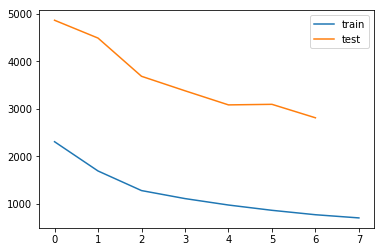

In [24]:
plt.plot(np.arange(N), train_loss, np.arange(N), test_loss)
plt.legend(["train", "test"])

In [37]:
from sklearn.metrics import log_loss
sk_train = []
sk_test = []
sk_boo = GradientBoostingRegressor(n_estimators=N, random_state=139)
sk_boo.fit(X_train, y_train)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=30, presort='auto', random_state=139,
             subsample=1.0, verbose=0, warm_start=False)

In [36]:
train_pred = list(sk_boo.staged_predict(X_train))
test_pred = list(sk_boo.staged_predict(X_test))

for item in train_pred:
    sk_train.append(log_loss(y_train, item))
    
for item in test_pred:
    sk_train.append(log_loss(y_test, item))
    
plt.plot(sk_train)
plt.plot(sk_test)
plt.legend(["train", "test"])

AttributeError: 'numpy.float64' object has no attribute 'append'

In [38]:
print("Test")
my_test = LogLoss(y_test, boo.predict(X_test))
sk_test = LogLoss(y_test, sk_boo.predict(X_test))
print(my_test)
print(sk_test)
print(my_test / sk_test)

print("Train")
my_train = LogLoss(y_train, boo.predict(X_train))
sk_train = LogLoss(y_train, sk_boo.predict(X_train))
print(my_train)
print(sk_train)
print(my_train / sk_train)


Test
nan
4758.3114376308695
nan
Train
nan
3739.549382515236
nan


/home/emil/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/emil/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [17]:
from sklearn.metrics import mean_squared_error

my = []
sk = []

max_depth = 20
for idx in tqdm(range(1, max_depth, 3)):
    my_clf = RegressionDecisionTree(max_depth=idx)
    sk_clf = DecisionTreeRegressor(max_depth=idx)
    my_clf.fit(X_train.astype(np.float64),y_train.astype(np.float64))
    sk_clf.fit(X_train.astype(np.float64),y_train.astype(np.float64))

    my.append(mean_squared_error(y_test, my_clf.predict(X_test)))
    sk.append(mean_squared_error(y_test, sk_clf.predict(X_test)))


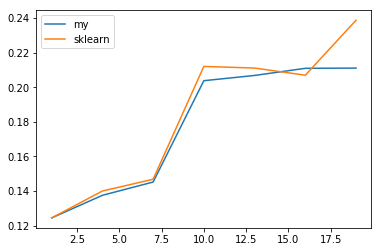

In [18]:
plt.plot(range(1, max_depth, 3), my, range(1, max_depth, 3), sk)
plt.legend(["my", "sklearn"])